In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

c:\Users\heave\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
file_path = r"C:\Users\heave\Downloads\Bron_Projects\Network Tracffic Analysis & Anomaly Detection\embedded_system_network_security_dataset.csv"

In [3]:
# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path and try again.")
    raise

Dataset loaded successfully!


In [4]:
# Expected columns
expected_columns = [
    'packet_size', 'inter_arrival_time', 'src_port', 'dst_port', 'packet_count_5s', 
    'mean_packet_size', 'spectral_entropy', 'frequency_band_energy', 'label', 
    'protocol_type_TCP', 'protocol_type_UDP', 'src_ip_192.168.1.2', 'src_ip_192.168.1.3', 
    'dst_ip_192.168.1.5', 'dst_ip_192.168.1.6', 'tcp_flags_FIN', 'tcp_flags_SYN', 
    'tcp_flags_SYN-ACK'
]

In [5]:
# Check for missing columns
missing_cols = [col for col in expected_columns if col not in df.columns]
if missing_cols:
    print(f"Warning: The following expected columns are missing: {missing_cols}")
    print("Using available columns instead.")
    features = df.drop(columns=[col for col in ['label'] if col in df.columns], errors='ignore')
else:
    features = df[expected_columns].drop('label', axis=1)

In [6]:
# Display sample data
print("\nSample Data Preview:")
display(df.head(8))


Sample Data Preview:


,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,protocol_type_TCP,protocol_type_UDP,src_ip_192.168.1.2,src_ip_192.168.1.3,dst_ip_192.168.1.5,dst_ip_192.168.1.6,tcp_flags_FIN,tcp_flags_SYN,tcp_flags_SYN-ACK
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,False,True,True,False,False,False,False,False,False
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,False,True,False,False,False,True,False,True,False
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,False,True,False,False,True,False,False,False,False
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,False,False,False,True,False,False,False,False,False
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,True,False,False,True,False,False,False,True,False
5,0.568361,0.207250,2619,53,0.928571,0.0,0.113375,0.582346,0.0,True,False,True,False,False,False,False,False,False
6,0.571940,0.363908,14582,53,0.714286,0.0,0.874457,0.760548,0.0,False,False,True,False,False,False,False,True,False
7,0.173228,0.075335,5724,443,0.428571,0.0,0.541747,0.175055,0.0,False,False,True,False,True,False,False,False,True


In [7]:
# Check if 'label' exists for evaluation
if 'label' not in df.columns:
    print("Warning: 'label' column not found. Assuming unsupervised learning with 5% anomalies.")
    df['label'] = 0  # Placeholder, will rely on model predictions

In [8]:
# Prepare features for modeling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [9]:
# Ground truth labels (if available)
y_true = df['label'] if 'label' in df.columns else None

In [10]:
# -# --- Model 1: Isolation Forest ---
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_pred = iso_forest.fit_predict(X_scaled)
iso_pred = np.where(iso_pred == -1, 1, 0)  # -1 (anomaly) to 1, 1 (normal) to 0
if y_true is not None:
    iso_accuracy = accuracy_score(y_true, iso_pred)
    print(f"\nIsolation Forest Accuracy: {iso_accuracy:.4f}")
    print("Classification Report (Isolation Forest):")
    print(classification_report(y_true, iso_pred))
    iso_cm = confusion_matrix(y_true, iso_pred)
else:
    iso_accuracy = None
    iso_cm = None
    print("\nIsolation Forest predictions made (no labels for accuracy).")



Isolation Forest Accuracy: 0.8640
Classification Report (Isolation Forest):
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93       900
         1.0       0.14      0.07      0.09       100

    accuracy                           0.86      1000
   macro avg       0.52      0.51      0.51      1000
weighted avg       0.83      0.86      0.84      1000



In [11]:
# --- Model 2: Local Outlier Factor ---
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_pred = lof.fit_predict(X_scaled)
lof_pred = np.where(lof_pred == -1, 1, 0)
if y_true is not None:
    lof_accuracy = accuracy_score(y_true, lof_pred)
    print(f"\nLocal Outlier Factor Accuracy: {lof_accuracy:.4f}")
    print("Classification Report (LOF):")
    print(classification_report(y_true, lof_pred))
    lof_cm = confusion_matrix(y_true, lof_pred)
else:
    lof_accuracy = None
    lof_cm = None
    print("\nLOF predictions made (no labels for accuracy).")


Local Outlier Factor Accuracy: 0.8560
Classification Report (LOF):
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       900
         1.0       0.06      0.03      0.04       100

    accuracy                           0.86      1000
   macro avg       0.48      0.49      0.48      1000
weighted avg       0.81      0.86      0.83      1000



In [12]:
# --- Model 3: Autoencoder ---
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(12, activation='relu')(input_layer)
encoded = Dense(6, activation='relu')(encoded)
decoded = Dense(12, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=30, batch_size=32, shuffle=True, verbose=0)

In [13]:
# Reconstruction error for anomaly detection
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)  # Top 5% as anomalies
auto_pred = (mse > threshold).astype(int)
if y_true is not None:
    auto_accuracy = accuracy_score(y_true, auto_pred)
    print(f"\nAutoencoder Accuracy: {auto_accuracy:.4f}")
    print("Classification Report (Autoencoder):")
    print(classification_report(y_true, auto_pred))
    auto_cm = confusion_matrix(y_true, auto_pred)
else:
    auto_accuracy = None
    auto_cm = None
    print("\nAutoencoder predictions made (no labels for accuracy).")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Autoencoder Accuracy: 0.8640
Classification Report (Autoencoder):
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93       900
         1.0       0.14      0.07      0.09       100

    accuracy                           0.86      1000
   macro avg       0.52      0.51      0.51      1000
weighted avg       0.83      0.86      0.84      1000



In [14]:
# --- Model Comparison ---
if y_true is not None:
    model_results = {
        'Isolation Forest': iso_accuracy,
        'Local Outlier Factor': lof_accuracy,
        'Autoencoder': auto_accuracy
    }
    best_model = max(model_results, key=model_results.get)
    print(f"\nBest Model: {best_model} with Accuracy: {model_results[best_model]:.4f}")
else:
    best_model = 'Autoencoder'  # Default to Autoencoder if no labels
    print("\nNo labels available. Defaulting to Autoencoder for predictions.")


Best Model: Isolation Forest with Accuracy: 0.8640


In [15]:
# Assign predictions from the best model
if best_model == 'Isolation Forest':
    final_pred = iso_pred
    best_cm = iso_cm
elif best_model == 'Local Outlier Factor':
    final_pred = lof_pred
    best_cm = lof_cm
else:
    final_pred = auto_pred
    best_cm = auto_cm

In [16]:
# Add predictions to DataFrame
df['anomaly_pred'] = final_pred

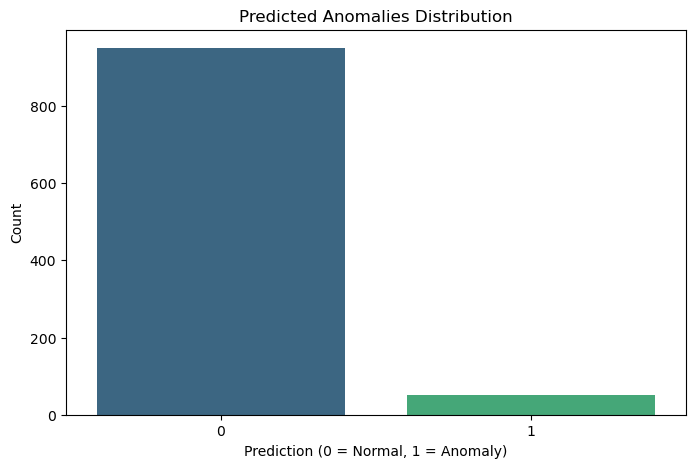

In [17]:
# --- Visualizations ---
# 1. Anomaly Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='anomaly_pred', data=df, palette='viridis')
plt.title('Predicted Anomalies Distribution')
plt.xlabel('Prediction (0 = Normal, 1 = Anomaly)')
plt.ylabel('Count')
plt.show()

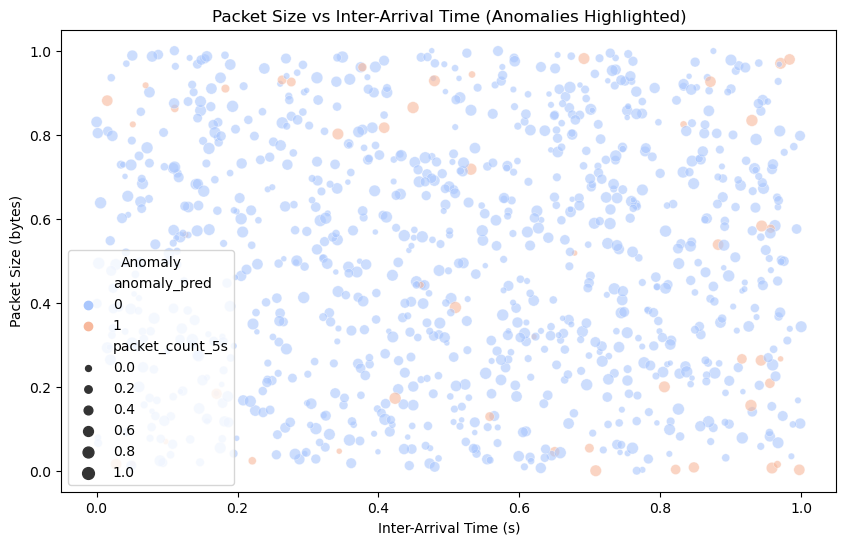

In [18]:
# 2. Scatter Plot: Packet Size vs Inter-Arrival Time (if columns exist)
if 'packet_size' in df.columns and 'inter_arrival_time' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='inter_arrival_time', y='packet_size', hue='anomaly_pred', 
                    size='packet_count_5s' if 'packet_count_5s' in df.columns else None, 
                    palette='coolwarm', data=df, alpha=0.6)
    plt.title('Packet Size vs Inter-Arrival Time (Anomalies Highlighted)')
    plt.xlabel('Inter-Arrival Time (s)')
    plt.ylabel('Packet Size (bytes)')
    plt.legend(title='Anomaly')
    plt.show()

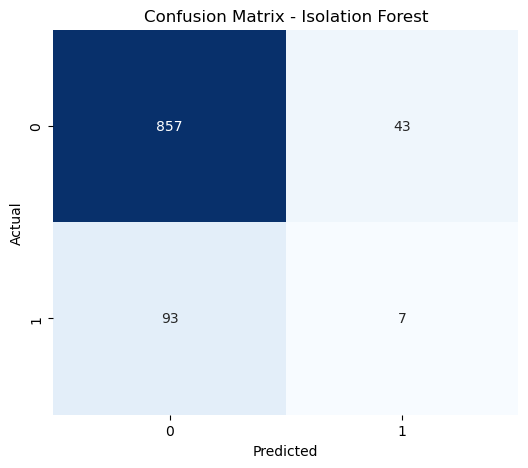

In [19]:
# 3. Confusion Matrix of Best Model (if labels exist)
if best_cm is not None:
    plt.figure(figsize=(6, 5))
    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {best_model}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

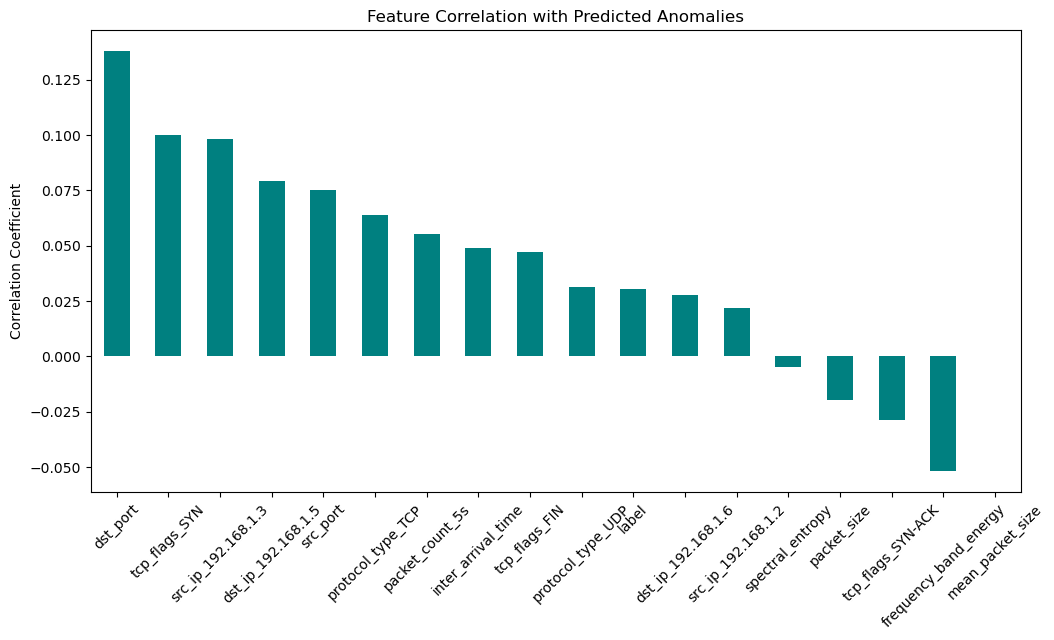

In [20]:
# 4. Feature Correlation with Anomalies
corr_with_anomaly = df.corr()['anomaly_pred'].sort_values(ascending=False)
plt.figure(figsize=(12, 6))
corr_with_anomaly[1:].plot(kind='bar', color='teal')
plt.title('Feature Correlation with Predicted Anomalies')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [21]:
# --- Root Cause Analysis ---
anomaly_df = df[df['anomaly_pred'] == 1]
normal_df = df[df['anomaly_pred'] == 0]

print("\nRoot Cause Analysis:")
if 'packet_size' in df.columns:
    print("1. Packet Size Stats (Normal vs Anomaly):")
    print(f" - Normal Mean: {normal_df['packet_size'].mean():.2f}, Anomaly Mean: {anomaly_df['packet_size'].mean():.2f}")
if 'inter_arrival_time' in df.columns:
    print("2. Inter-Arrival Time Stats (Normal vs Anomaly):")
    print(f" - Normal Mean: {normal_df['inter_arrival_time'].mean():.2f}, Anomaly Mean: {anomaly_df['inter_arrival_time'].mean():.2f}")
if 'packet_count_5s' in df.columns:
    print("3. Packet Count in 5s (Normal vs Anomaly):")
    print(f" - Normal Mean: {normal_df['packet_count_5s'].mean():.2f}, Anomaly Mean: {anomaly_df['packet_count_5s'].mean():.2f}")
if all(col in df.columns for col in ['protocol_type_TCP', 'protocol_type_UDP']):
    print("4. Protocol Type Distribution in Anomalies:")
    print(anomaly_df[['protocol_type_TCP', 'protocol_type_UDP']].mean())
if all(col in df.columns for col in ['src_ip_192.168.1.2', 'src_ip_192.168.1.3']):
    print("5. Source IP Involvement in Anomalies:")
    print(anomaly_df[['src_ip_192.168.1.2', 'src_ip_192.168.1.3']].mean())



Root Cause Analysis:
1. Packet Size Stats (Normal vs Anomaly):
 - Normal Mean: 0.50, Anomaly Mean: 0.48
2. Inter-Arrival Time Stats (Normal vs Anomaly):
 - Normal Mean: 0.51, Anomaly Mean: 0.57
3. Packet Count in 5s (Normal vs Anomaly):
 - Normal Mean: 0.50, Anomaly Mean: 0.58
4. Protocol Type Distribution in Anomalies:
protocol_type_TCP    0.44
protocol_type_UDP    0.42
dtype: float64
5. Source IP Involvement in Anomalies:
src_ip_192.168.1.2    0.36
src_ip_192.168.1.3    0.54
dtype: float64


In [22]:
# --- Actionable Insights ---
print("\nActionable Insights:")
print(f"- Best Model ({best_model}): Detected {df['anomaly_pred'].sum()} anomalies out of {len(df)} packets.")
if y_true is not None:
    print(f"- Accuracy: {model_results[best_model]:.4f}, with {best_cm[1,1]} out of {y_true.sum()} true anomalies detected.")
print("- Key Triggers: Check for high packet sizes, rapid inter-arrival times, or unusual packet counts.")
print("- Potential Causes: Network congestion, DDoS, or device malfunctions.")
print("- Recommendation: Deploy this model for real-time monitoring and investigate high-risk IPs or protocols.")


Actionable Insights:
- Best Model (Isolation Forest): Detected 50 anomalies out of 1000 packets.
- Accuracy: 0.8640, with 7 out of 100.0 true anomalies detected.
- Key Triggers: Check for high packet sizes, rapid inter-arrival times, or unusual packet counts.
- Potential Causes: Network congestion, DDoS, or device malfunctions.
- Recommendation: Deploy this model for real-time monitoring and investigate high-risk IPs or protocols.


In [23]:
# --- Simulate Real-Time Detection (Sample of 5 New Packets) ---
print("\nSimulating Real-Time Detection (Sample of 5 New Packets):")
new_data = pd.DataFrame({
    'packet_size': [500, 1200, 450, 1500, 600],
    'inter_arrival_time': [0.1, 0.03, 0.12, 0.02, 0.09],
    'src_port': [54321, 12345, 23456, 34567, 45678],
    'dst_port': [80, 443, 8080, 22, 21],
    'packet_count_5s': [8, 20, 7, 25, 9],
    'mean_packet_size': [480, 1100, 460, 1400, 590],
    'spectral_entropy': [2.5, 4.0, 2.0, 4.5, 3.0],
    'frequency_band_energy': [950, 1200, 900, 1300, 1000],
    'protocol_type_TCP': [1, 1, 0, 1, 0],
    'protocol_type_UDP': [0, 0, 1, 0, 1],
    'src_ip_192.168.1.2': [1, 0, 0, 1, 0],
    'src_ip_192.168.1.3': [0, 1, 1, 0, 1],
    'dst_ip_192.168.1.5': [0, 1, 0, 0, 1],
    'dst_ip_192.168.1.6': [1, 0, 1, 1, 0],
    'tcp_flags_FIN': [0, 0, 0, 0, 1],
    'tcp_flags_SYN': [1, 0, 0, 1, 0],
    'tcp_flags_SYN-ACK': [0, 1, 0, 0, 0]
}, columns=features.columns)  # Match feature columns

new_scaled = scaler.transform(new_data)
if best_model == 'Isolation Forest':
    new_pred = iso_forest.predict(new_scaled)
    new_pred = np.where(new_pred == -1, 1, 0)
elif best_model == 'Local Outlier Factor':
    new_pred = lof.fit_predict(new_scaled)
    new_pred = np.where(new_pred == -1, 1, 0)
else:
    new_recon = autoencoder.predict(new_scaled)
    new_mse = np.mean(np.power(new_scaled - new_recon, 2), axis=1)
    new_pred = (new_mse > threshold).astype(int)
    
new_data['anomaly_pred'] = new_pred
print(new_data[['packet_size', 'inter_arrival_time', 'packet_count_5s', 'anomaly_pred']])


Simulating Real-Time Detection (Sample of 5 New Packets):
   packet_size  inter_arrival_time  packet_count_5s  anomaly_pred
0          500                0.10                8             1
1         1200                0.03               20             1
2          450                0.12                7             1
3         1500                0.02               25             1
4          600                0.09                9             1
